In [1]:
#%%
import os
import FinanceDataReader as fdr
from bt.algos import RunDaily
from pypfopt.expected_returns import prices_from_returns
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns
import sys

pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False

from IPython.display import display, HTML

# sys.path.insert(0, "/Users/hosung/workspace/git/bt/")
# for p in sys.path:
#     print(p)
%matplotlib inline

import bt
bt.__version__

(0, 2, 9)

In [2]:
def long_only_ew(data, tickers, start_date, name='long_only_ew', initial_capital=1000000.0):
    s = bt.Strategy(name,
    [
        bt.algos.RunAfterDate(start_date),
        bt.algos.RunOnce(),
        bt.algos.SelectThese(tickers),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ])
    return bt.Backtest(s, data, initial_capital=initial_capital)

In [3]:
df = pd.read_csv('asset_db.csv', index_col=0, parse_dates=True)

In [4]:
cols = ['nasdaq100_UH', 'kbond20y', 'kodex200x2', 'usdkrwx2']
price_df = df[cols].copy()
#nasdaq100_UH 1985-10-02 00:00:00
#kbond20y 1981-05-01 00:00:00
#kodex200x2 1981-05-01 00:00:00
#usdkrwx2 1981-05-01 00:00:00


In [5]:
price_df['1985-10'].tail(2)

/var/folders/68/pm9snk_d53j26rdq0n4v_jn80000gn/T/ipykernel_79509/572385914.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  price_df['1985-10'].tail(2)


,nasdaq100_UH,kbond20y,kodex200x2,usdkrwx2
Date,,,,
1985-10-30,443.9889,819.4888,527.9910,4753.0506
1985-10-31,442.7283,821.6153,520.8193,4750.2029


In [6]:
price_df['1986-10'].tail(2)

/var/folders/68/pm9snk_d53j26rdq0n4v_jn80000gn/T/ipykernel_79509/779653957.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  price_df['1986-10'].tail(2)


,nasdaq100_UH,kbond20y,kodex200x2,usdkrwx2
Date,,,,
1986-10-30,544.2618,981.1386,1454.1757,4662.7489
1986-10-31,543.1959,979.4770,1457.7345,4664.1452


In [7]:
price_df.tail(2)

,nasdaq100_UH,kbond20y,kodex200x2,usdkrwx2
Date,,,,
2021-09-30,78930.0000,126480.0000,24560.0000,10105.0000
2021-10-01,77670.0000,125820.0000,23610.0000,10170.0000


In [8]:
start_date = '1986-10-30'
price_df = price_df.dropna()['1985-10-30':]

In [9]:
def strategy_aibeta(price_df, lookback=3, max=0.5):
    st = bt.Strategy(f"AIBeta_{lookback}_{max:.2f}",
                    [
                        bt.algos.RunAfterDate(start_date),
                        bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True),
                        # bt.algos.PrintDate(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighMeanVar(lookback=pd.DateOffset(months=lookback), lag = pd.DateOffset(days=1),
                                            bounds=(0.0, max), covar_method='ledoit-wolf'),
                        bt.algos.Rebalance()
                    ])
    bt_ai_beta = bt.Backtest(st, price_df)
    return bt_ai_beta

In [10]:
test_aibeta = {}
for lookback in range(3, 13):
    # print(f"lookback : {lookback}")
    for bound in np.arange(0.35, 0.5, 0.05):
        test_aibeta[f'AIBeta_{lookback}_{bound:.2f}'] = strategy_aibeta(price_df, lookback, bound)
# %%
rm = bt.run(*test_aibeta.values())

/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [11]:
stats = rm.prices[start_date:].calc_stats().stats
stats

,AIBeta_3_0.35,AIBeta_3_0.40,AIBeta_3_0.45,AIBeta_3_0.50,AIBeta_4_0.35,AIBeta_4_0.40,AIBeta_4_0.45,AIBeta_4_0.50,AIBeta_5_0.35,AIBeta_5_0.40,...,AIBeta_10_0.45,AIBeta_10_0.50,AIBeta_11_0.35,AIBeta_11_0.40,AIBeta_11_0.45,AIBeta_11_0.50,AIBeta_12_0.35,AIBeta_12_0.40,AIBeta_12_0.45,AIBeta_12_0.50
start,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,...,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00
end,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,...,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00
rf,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
total_return,430.5320,438.4282,473.6215,505.6890,271.9309,312.6535,339.3351,348.4834,222.3946,254.4174,...,342.4075,364.3605,350.2476,328.3828,337.9786,346.6919,289.0247,289.2584,290.5806,284.4743
cagr,0.1898,0.1904,0.1930,0.1952,0.1742,0.1789,0.1817,0.1826,0.1675,0.1720,...,0.1820,0.1841,0.1828,0.1806,0.1816,0.1824,0.1763,0.1763,0.1765,0.1758
max_drawdown,-0.4018,-0.4299,-0.4444,-0.4559,-0.4709,-0.4459,-0.4522,-0.4570,-0.4555,-0.4488,...,-0.4042,-0.4167,-0.3643,-0.3968,-0.4121,-0.4189,-0.3664,-0.4038,-0.4170,-0.4249
calmar,0.4722,0.4428,0.4343,0.4282,0.3700,0.4013,0.4018,0.3995,0.3678,0.3833,...,0.4502,0.4417,0.5017,0.4551,0.4406,0.4355,0.4811,0.4367,0.4232,0.4137
mtd,-0.0049,-0.0049,-0.0048,-0.0048,-0.0063,-0.0062,-0.0059,-0.0052,-0.0062,-0.0061,...,-0.0094,-0.0084,-0.0134,-0.0120,-0.0109,-0.0098,-0.0149,-0.0131,-0.0119,-0.0118
three_month,-0.0026,-0.0010,0.0007,0.0021,0.0058,0.0110,0.0153,0.0192,0.0019,0.0081,...,-0.0127,-0.0141,-0.0238,-0.0220,-0.0269,-0.0331,-0.0178,-0.0206,-0.0210,-0.0249
six_month,0.0561,0.0565,0.0538,0.0520,0.0636,0.0633,0.0664,0.0699,0.0589,0.0645,...,0.0475,0.0482,0.0321,0.0327,0.0281,0.0234,0.0414,0.0374,0.0379,0.0343


In [12]:
# stats.to_csv('AIBeta_results_extend.csv')

In [13]:
stats = stats.loc[['total_return', 'cagr', 'max_drawdown', 'daily_sharpe'],:].T
stats.columns = ['return', 'cagr', 'mdd', 'sharpe']
stats['mdd'] = stats['mdd']*-1
stats.sort_values(by='return', ascending=False)

,return,cagr,mdd,sharpe
AIBeta_3_0.50,505.6890,0.1952,0.4559,1.0087
AIBeta_3_0.45,473.6215,0.1930,0.4444,1.0429
AIBeta_3_0.40,438.4282,0.1904,0.4299,1.0704
AIBeta_3_0.35,430.5320,0.1898,0.4018,1.0995
AIBeta_6_0.50,425.1120,0.1893,0.4317,0.9718
AIBeta_6_0.45,371.2422,0.1847,0.4310,0.9936
AIBeta_7_0.50,367.9307,0.1844,0.4064,0.9637
AIBeta_10_0.50,364.3605,0.1841,0.4167,0.9793
AIBeta_10_0.35,352.7347,0.1830,0.3459,1.0789
AIBeta_11_0.35,350.2476,0.1828,0.3643,1.0790


<AxesSubplot:>

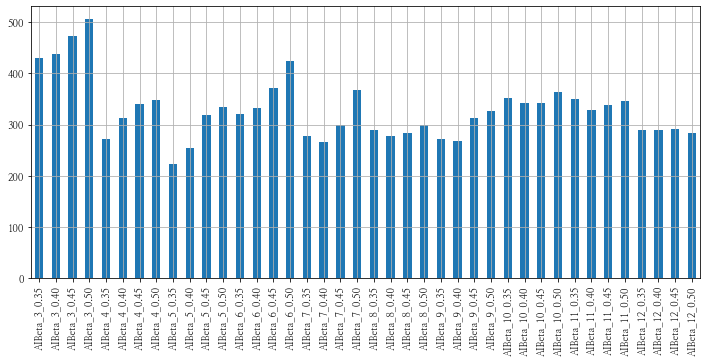

In [14]:
stats['return'].plot.bar(figsize=(12, 5))#, secondary_y=['mdd'])

<AxesSubplot:>

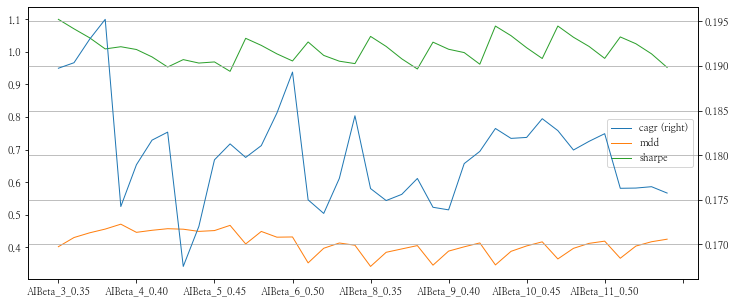

In [15]:
stats[['cagr', 'mdd', 'sharpe']].plot(figsize=(12,5), secondary_y=['cagr'])

In [16]:
bt_ew = long_only_ew(price_df, cols, start_date, "ew")

bt_kodex200x2 = long_only_ew(price_df, ["kodex200x2"], start_date, "kodex200x2")
bt_kbond20y = long_only_ew(price_df, ["kbond20y"], start_date, "kbond20y")
bt_nasdaq100_UH = long_only_ew(price_df, ["nasdaq100_UH"], start_date, "nasdaq100_UH")
bt_usdkrwx2 = long_only_ew(price_df, ["usdkrwx2"], start_date, "usdkrwx2")

bt_ai_beta_35 = strategy_aibeta(price_df, 3, 0.35)
bt_ai_beta_50 = strategy_aibeta(price_df, 3, 0.50)

In [17]:
r = bt.run(bt_ai_beta_35, bt_ai_beta_50, bt_kodex200x2, bt_kbond20y, bt_nasdaq100_UH, bt_usdkrwx2)

In [18]:
r.set_date_range(start=start_date)
r.display()

Stat                 AIBeta_3_0.35    AIBeta_3_0.50    kodex200x2    kbond20y    nasdaq100_UH    usdkrwx2
-------------------  ---------------  ---------------  ------------  ----------  --------------  ----------
Start                1986-10-30       1986-10-30       1986-10-30    1986-10-30  1986-10-30      1986-10-30
End                  2021-10-01       2021-10-01       2021-10-01    2021-10-01  2021-10-01      2021-10-01
Risk-free rate       0.00%            0.00%            0.00%         0.00%       0.00%           0.00%

Total Return         43053.20%        50568.90%        1517.43%      12733.73%   14191.33%       117.83%
Daily Sharpe         1.10             1.01             0.40          1.24        0.64            0.21
Daily Sortino        1.79             1.62             0.66          1.87        1.05            0.33
CAGR                 18.98%           19.52%           8.30%         14.91%      15.27%          2.25%
Max Drawdown         -40.18%          -45.59%         

/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1389: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


<AxesSubplot:>

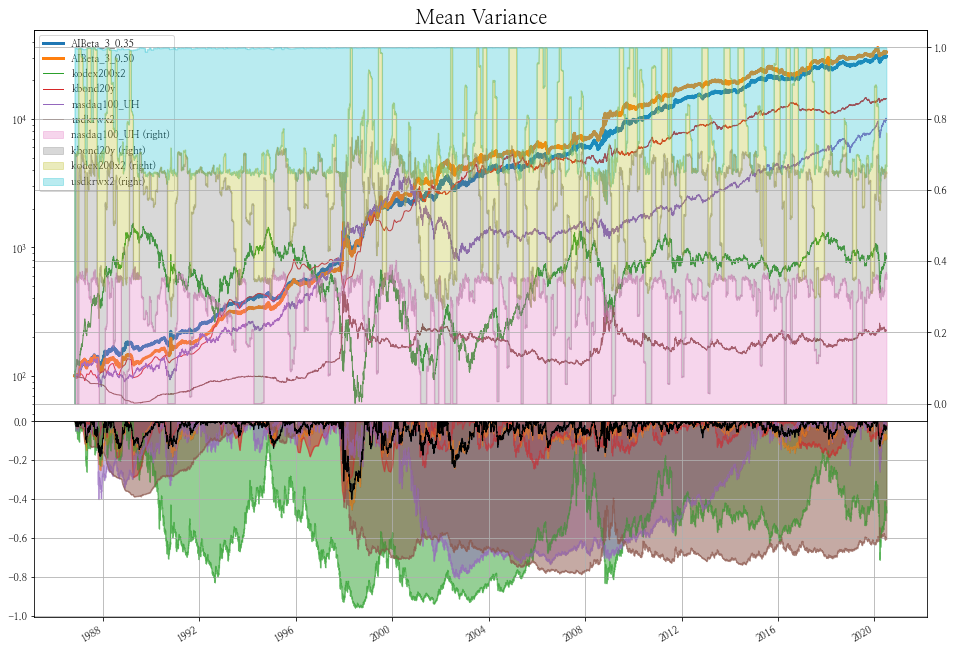

In [19]:
res1 = r
start = start_date
end = '2020-06-30'
plt.rcParams["figure.figsize"] = [16, 12]
plt.subplots_adjust(hspace=0)

# 첫번째 칸에 그림을 그린다.
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
# 두개를 한 칸에 그리기 위해 ax=ax1으로 axis공유
ax2 = res1.prices[start:end].plot(ax=ax1, style=['-', '-', '-', '-', '-', '-', '-'], lw=1, logy=True) # 모든 데이터 r_all
for line in ax2.get_lines():
    if line.get_label() == 'AIBeta_3_0.35' or line.get_label() == 'AIBeta_3_0.50' or line.get_label() == 'AIBet_InvVol':
        line.set_linewidth(3)
plt.legend(loc="upper left");
plt.title('Mean Variance', fontsize=20)
res1.get_security_weights('AIBeta_3_0.35')[start:end].plot.area(alpha=0.3, ax=ax1, secondary_y=True)


# 두번째 칸에 그림을 그린다.
# drawdown을 그림다. 두개를 하나에 그리기 위해 ax=ax2로 axis를 공유
ax2 = plt.subplot2grid((3,1), (2,0))
res1.prices[start:end].to_drawdown_series().plot.area(stacked=False,legend=False, ax=ax2)
res1.prices.loc[start:end,'AIBeta_3_0.35'].to_drawdown_series().plot(legend=False, color='black', alpha=1, lw=1, ls='-', ax=ax2)


In [20]:
r.display_monthly_returns('AIBeta_3_0.35')

  Year    Jan    Feb     Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  ------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
  1986   0      0       0      0      0      0      0      0      0     -0     -1.02   2.19   1.14
  1987  16.38   6.61    5.52  -9.33   5.92   6.29   2.28   0.51  -1.62  -6.81  -3.24   7.37  30.84
  1988  15.68  -4.3     8.5    0.51   4.02  -3.44  -2.61  -7.47   2.61   5.88   5.18   9.07  36.21
  1989  -0.76   0.99   -6.67  -2.3    1.97  -6.36   2.73   4.3    1.18   0.82   1.57   0.66  -2.49
  1990   1.64   2.63    0.93  -1.72   5.24   2.25  -1.55  -6.75  -2.25  11.44   1.09   1     13.69
  1991   2.99   4.03    1.93   0.68   1.32  -2.09   2.4   -1.89   1.75   2.5    0.53   4.79  20.39
  1992   5.47   2.25   -0.39   0.34   2.27   1.57   6.03   0.26   5.05   6.53   0.55   3.22  38.23
  1993   3.85   2.3     3.69  -0.78   1.7   -1.16  -2.43  -3.11   6.51   1.27   1.46   3.04  17.12
  1994   4

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               1986-10-31  1986-10-31
End Period                 2021-10-01  2021-10-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          43,053.20%  50,568.90%
CAGR﹪                     18.96%      19.51%

Sharpe                     1.1         1.01
Smart Sharpe               1.02        0.93
Sortino                    1.64        1.51
Smart Sortino              1.52        1.4
Sortino/√2                 1.16        1.07
Smart Sortino/√2           1.08        0.99
Omega                      1.26        1.26

Max Drawdown               -40.18%     -45.59%
Longest DD Days            485         622
Volatility (ann.)          16.37%      18.69%
R^2                        0.88        0.88
Calmar                     0.47        0.43
Skew                       -0.11       0.24
Kurtosis                   62.33     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,1997-12-24,1998-04-28,1998-11-16,327,-40.1827,-38.7933
2,2002-04-19,2002-08-05,2003-06-18,425,-23.7027,-22.8694
3,1997-12-12,1997-12-16,1997-12-23,11,-21.7738,-18.5735
4,1987-08-22,1987-11-16,1988-01-26,157,-18.0475,-17.8407
5,2001-01-26,2001-04-10,2001-11-23,301,-17.4423,-16.4156


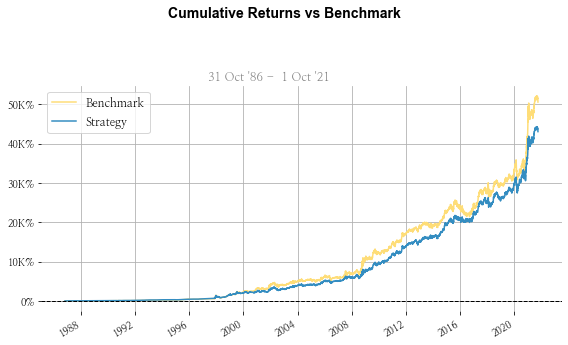

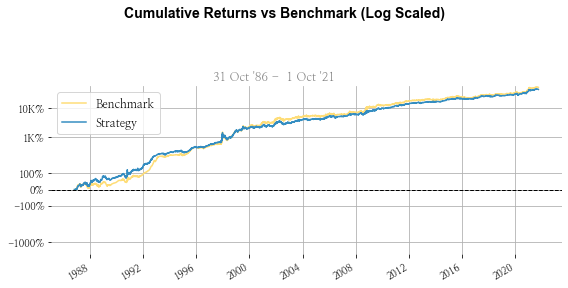

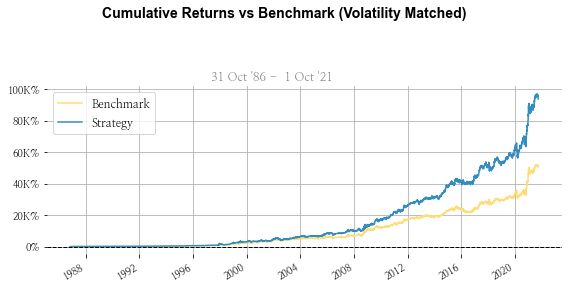

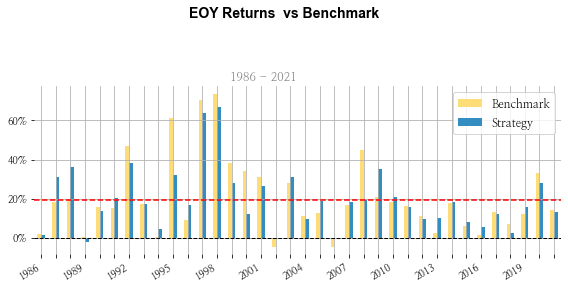

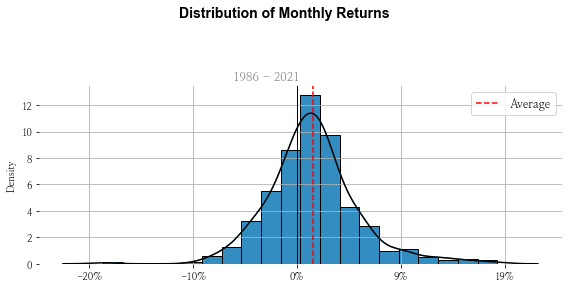

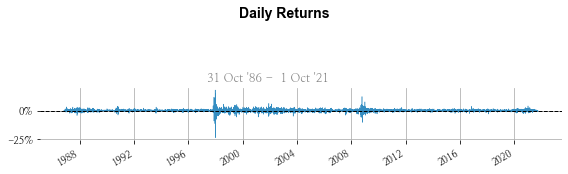

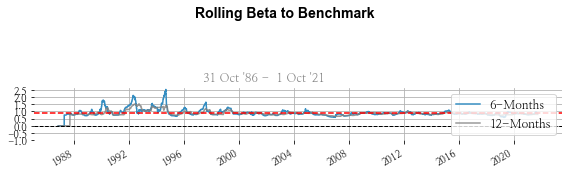

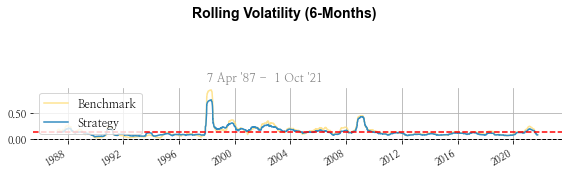

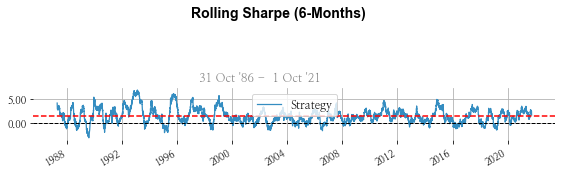

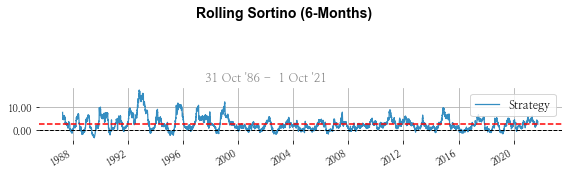

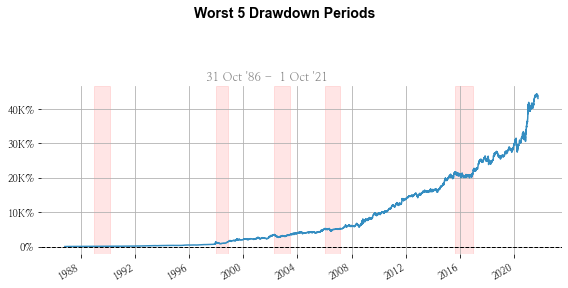

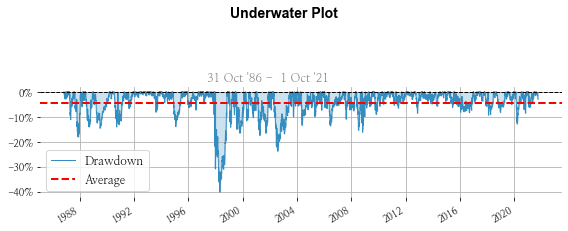

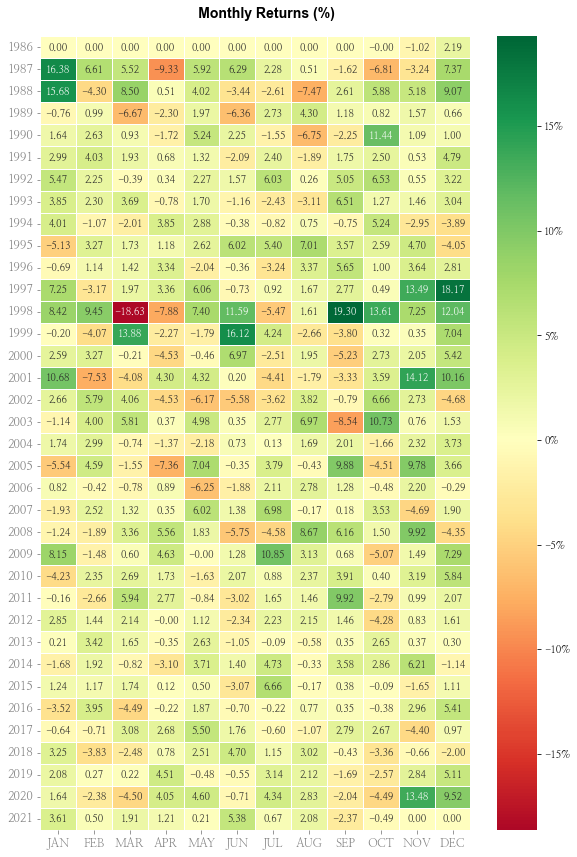

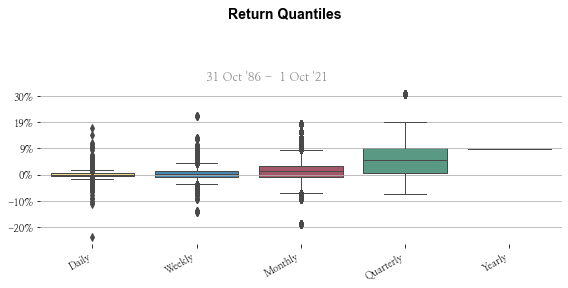

In [21]:
qs.reports.full(r.prices['AIBeta_3_0.35'].to_returns().dropna(), r.prices['AIBeta_3_0.50'].to_returns().dropna())

In [22]:
r.prices.calc_cagr()

AIBeta_3_0.35   0.1898
AIBeta_3_0.50   0.1952
kodex200x2      0.0830
kbond20y        0.1491
nasdaq100_UH    0.1527
usdkrwx2        0.0225
dtype: float64

2021-10-01 00:00:00


<AxesSubplot:>

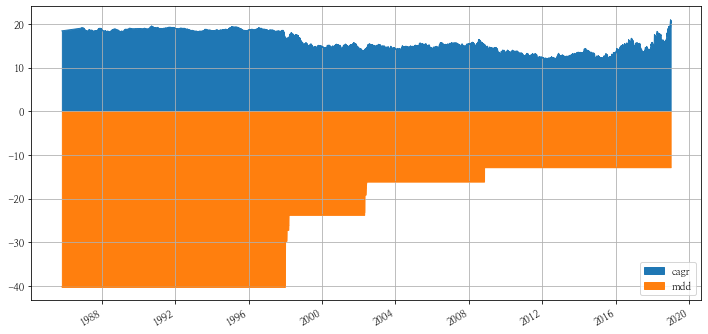

In [23]:
r_ai = bt.run(bt_ai_beta_35)
cagrs = {}
mdds = {}
# for m in pd.date_range(start_date, '2021-10', freq='M'):
for m in r_ai.prices.index:
    # print(m)
    try:
        cagrs[m] = r_ai.prices[m:].calc_cagr().values[0]
        mdds[m] = r_ai.prices[m:].calc_max_drawdown().values[0]
    except:
        print(m)

cagr_df = pd.DataFrame([cagrs]).T*100
mdd_df = pd.DataFrame([mdds]).T*100

tdf = bt.merge(cagr_df, mdd_df)
tdf.columns = ['cagr', 'mdd']

tdf[:'2018'].plot.area(figsize=(12,6))

In [24]:
# tdf.to_csv("AIBeta_3개월_0.35_CAGR_MDD.csv")

2021-10-01 00:00:00


<AxesSubplot:>

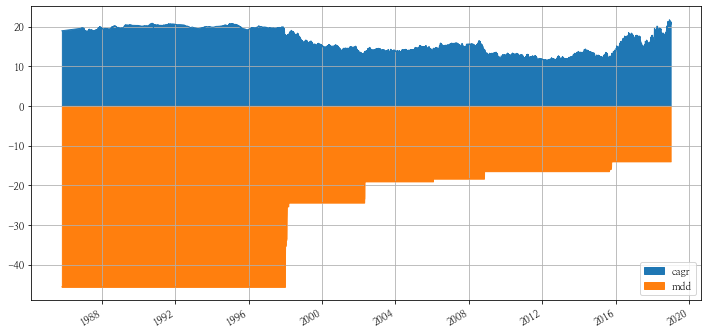

In [25]:
r_ai = bt.run(bt_ai_beta_50)
cagrs = {}
mdds = {}
# for m in pd.date_range(start_date, '2021-10', freq='M'):
for m in r_ai.prices.index:
    # print(m)
    try:
        cagrs[m] = r_ai.prices[m:].calc_cagr().values[0]
        mdds[m] = r_ai.prices[m:].calc_max_drawdown().values[0]
    except:
        print(m)

cagr_df = pd.DataFrame([cagrs]).T*100
mdd_df = pd.DataFrame([mdds]).T*100

tdf = bt.merge(cagr_df, mdd_df)
tdf.columns = ['cagr', 'mdd']

tdf[:'2018'].plot.area(figsize=(12,6))

In [26]:
# tdf.to_csv("AIBeta_3개월_0.50_CAGR_MDD.csv")

(0.0, 1.0)

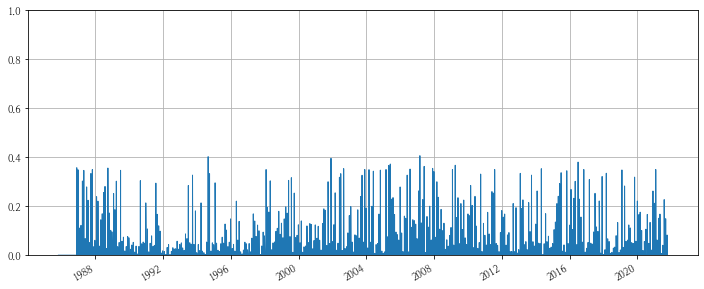

In [27]:
ax = bt_ai_beta_35.turnover.plot(figsize=(12,5))
ax.set_ylim(0.0, 1.0)

(0.0, 1.0)

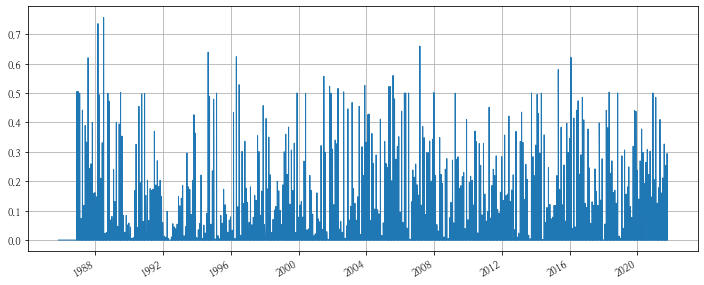

In [28]:
bt_ai_beta_50.turnover.plot(figsize=(12,5))
ax.set_ylim(0.0, 1.0)